##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Probability Case Study: Covariance Estimation

I wrote this notebook as a case study to learn TensorFlow Probability.  The problem I chose to solve is estimating a covariance matrix for samples of a 2-D mean 0 Gaussian random variable.  The problem has a couple of nice features:

* If we use an inverse Wishart prior for the covariance (a common approach), the problem has an analytic solution, so we can check our results.
* The problem involves sampling a constrained parameter, which adds some interesting complexity.
* The most straightforward solution is not the fastest one, so there is some optimization work to do.

I decided to write my experiences up as I went along. It took me awhile to wrap my head around the finer points of TFP, so this notebook starts fairly simply and then gradually works up to more complicated TFP features.  I ran into lots of problems along the way, and I've tried to capture both the processes that helped me identify them and the workarounds I eventually found.  I've tried to include *lots* of detail (including lots of tests to make sure individual steps are correct).

## Why learn TensorFlow Probability?

I found TensorFlow Probability appealing for my project for a few reasons:

* TensorFlow probability lets you prototype and develop complex models interactively in a notebook.  You can break your code up into small pieces that you can test interactively and with unit tests.
* Once you're ready to scale up, you can take advantage of all of the infrastructure we have in place for making TensorFlow run on multiple, optimized processors on multiple machines.
* Finally, while I really like Stan, I find it quite difficult to debug.  You have to write all your modeling code in a standalone language that has very few tools for letting you poke at your code, inspect intermediate states, and so on.

The downside is that TensorFlow Probability is much newer than Stan and PyMC3, so the documentation is a work in progress, and there's lots of functionality that's yet to be built.  Happily, I found TFP's foundation to be solid, and it's designed in a modular way that allows one to extend its functionality fairly straightforwardly.  In this notebook, in addition to solving the case study, I'll show some ways to go about extending TFP.

## Who this is for

I'm assuming that readers are coming to this notebook with some important prerequisites.  You should:

* Know the basics of Bayesian inference.  (If you don't, a really nice first book is *[Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/)*)
* Have some familiarity with an MCMC sampling library, e.g. [Stan](http://mc-stan.org/) / [PyMC3](http://docs.pymc.io/) / [BUGS](https://www.mrc-bsu.cam.ac.uk/software/bugs/)
* Have a solid grasp of [NumPy](http://www.numpy.org/)  (One good intro is *[Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do)*)
* Have at least passing familiarity with [TensorFlow](https://www.tensorflow.org/), but not necessarily expertise.  (*[Learning TensorFlow](http://shop.oreilly.com/product/0636920063698.do)* is good, but TensorFlow's rapid evolution means that most books will be a bit dated.  Stanford's [CS20](https://web.stanford.edu/class/cs20si/) course is also good.)

# First attempt

Here's my first attempt at the problem.  Spoiler: my solution doesn't work, and it's going to take several attempts to get things right!  Although the process takes awhile, each attempt below has been useful for learning a new part of TFP.

One note: TFP doesn't currently implement the inverse Wishart distribution (we'll see at the end how to roll our own inverse Wishart), so instead I'll change the problem to that of estimating a precision matrix using a Wishart prior.

In [4]:
import collections
import math
import os
import time

import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Step 1: get the observations together

My data here are all synthetic, so this is going to seem a bit tidier than a real-world example.  However, there's no reason you can't generate some synthetic data of your own.

**Tip**: Once you've decided on the form of your model, you can pick some parameter values and use your chosen model to generate some synthetic data.  As a sanity check of your implementation, you can then verify that your estimates include the true values of the parameters you chose.  To make your debugging / testing cycle faster, you might consider a simplified version of your model (e.g. use fewer dimensions or fewer samples).


**Tip:** It's easiest to work with your observations as NumPy arrays.  One important thing to note is that NumPy by default uses float64's, while TensorFlow by default uses float32's. 

In general, TensorFlow operations want all arguments to have the same type, and you have to do explicit data casting to change types.  If you use float64 observations, you'll need to add in a lot of cast operations.  NumPy, in contrast, will take care of casting automatically.  Hence, **it is *much* easier to convert your Numpy data into float32 than it is to force TensorFlow to use float64.** 

### Choose some parameter values

In [5]:
# We're assuming 2-D data with a known true mean of (0, 0)
true_mean = np.zeros([2], dtype=np.float32)
# We'll make the 2 coordinates correlated
true_cor = np.array([[1.0, 0.9], [0.9, 1.0]], dtype=np.float32)
# And we'll give the 2 coordinates different variances
true_var = np.array([4.0, 1.0], dtype=np.float32)
# Combine the variances and correlations into a covariance matrix
true_cov = np.expand_dims(np.sqrt(true_var), axis=1).dot(
    np.expand_dims(np.sqrt(true_var), axis=1).T) * true_cor
# We'll be working with precision matrices, so we'll go ahead and compute the
# true precision matrix here
true_precision = np.linalg.inv(true_cov)

In [6]:
# Here's our resulting covariance matrix
print(true_cov)
# Verify that it's positive definite, since np.random.multivariate_normal
# complains about it not being positive definite for some reason.
# (Note that I'll be including a lot of sanity checking code in this notebook -
# it's a *huge* help for debugging)
print('eigenvalues: ', np.linalg.eigvals(true_cov))

[[4.  1.8]
 [1.8 1. ]]
eigenvalues:  [4.843075   0.15692513]


### Generate some synthetic observations

Note that **TensorFlow Probability uses the convention that the initial dimension(s) of your data represent sample indices, and the final dimension(s) of your data represent the dimensionality of your samples.**

Here we want 100 samples, each of which is a vector of length 2.  We'll generate an array `my_data` with shape (100, 2).  `my_data[i, :]` is the $i$th sample, and it is a vector of length 2.

(Remember to make `my_data` have type float32!)

In [7]:
# Set the seed so the results are reproducible.
np.random.seed(123)

# Now generate some observations of our random variable.
# (Note that I'm suppressing a bunch of spurious about the covariance matrix
# not being positive semidefinite via check_valid='ignore' because it really is
# positive definite!)
my_data = np.random.multivariate_normal(
    mean=true_mean, cov=true_cov, size=100,
    check_valid='ignore').astype(np.float32)

In [8]:
my_data.shape

(100, 2)

### Sanity check the observations

One potential source of bugs is messing up your synthetic data!  Let's do some simple checks.

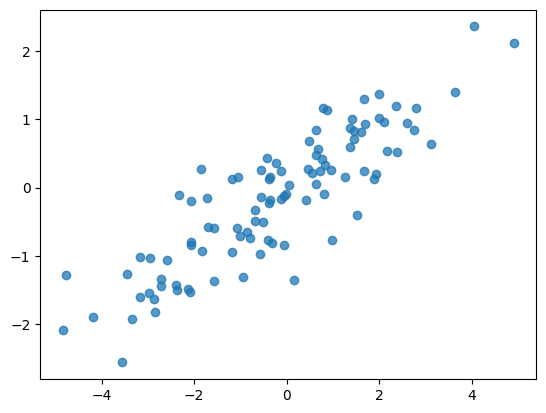

In [9]:
# Do a scatter plot of the observations to make sure they look like what we
# expect (higher variance on the x-axis, y values strongly correlated with x)
plt.scatter(my_data[:, 0], my_data[:, 1], alpha=0.75)
plt.show()

In [10]:
print('mean of observations:', np.mean(my_data, axis=0))
print('true mean:', true_mean)

mean of observations: [-0.24009615 -0.16638893]
true mean: [0. 0.]


In [11]:
print('covariance of observations:\n', np.cov(my_data, rowvar=False))
print('true covariance:\n', true_cov)

covariance of observations:
 [[3.95307734 1.68718486]
 [1.68718486 0.94910269]]
true covariance:
 [[4.  1.8]
 [1.8 1. ]]


Ok, our samples look reasonable.  Next step.

## Step 2: Implement the likelihood function in NumPy

The main thing we'll need to write to perform our MCMC sampling in TF Probability is a log likelihood function.  In general it's a bit trickier to write TF than NumPy, so I find it helpful to do an initial implementation in NumPy.  I'm going to split the likelihood function into 2 pieces, a data likelihood function that corresponds to $P(data | parameters)$ and a prior likelihood function that corresponds to $P(parameters)$.

Note that these NumPy functions don't have to be super optimized / vectorized since the goal is just to generate some values for testing.  Correctness is the key consideration!

First we'll implement the data log likelihood piece.  That's pretty straightforward.  The one thing to remember is that we're going to be working with precision matrices, so we'll parameterize accordingly.

In [12]:
def log_lik_data_numpy(precision, data):
  # np.linalg.inv is a really inefficient way to get the covariance matrix, but
  # remember we don't care about speed here
  cov = np.linalg.inv(precision)
  rv = scipy.stats.multivariate_normal(true_mean, cov)
  return np.sum(rv.logpdf(data))

# test case: compute the log likelihood of the data given the true parameters
log_lik_data_numpy(true_precision, my_data)

-280.81822950593767

We're going to use a Wishart prior for the precision matrix since there's an analytical solution for the posterior (see [Wikipedia's handy table of conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior#Continuous_distributions)).

The [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution) has 2 parameters: 

* the number of *degrees of freedom* (labeled $\nu$ in Wikipedia)
* a *scale matrix* (labeled $V$ in Wikipedia)

The mean for a Wishart distribution with parameters $\nu, V$ is $E[W] = \nu V$, and the variance is $\text{Var}(W_{ij}) = \nu(v_{ij}^2+v_{ii}v_{jj})$

Some useful intuition: You can generate a Wishart sample by generating $\nu$ independent draws $x_1 \ldots x_{\nu}$ from a multivariate normal random variable with mean 0 and covariance $V$ and then forming the sum $W = \sum_{i=1}^{\nu} x_i x_i^T$.

If you rescale Wishart samples by dividing them by $\nu$, you get the sample covariance matrix of the $x_i$.  This sample covariance matrix should tend toward $V$ as $\nu$ increases.  When $\nu$ is small, there is lots of variation in the sample covariance matrix, so small values of $\nu$ correspond to weaker priors and large values of $\nu$ correspond to stronger priors.  Note that $\nu$ must be at least as large as the dimension of the space you're sampling or you'll generate singular matrices.

We'll use $\nu = 3$ so we have a weak prior, and we'll take $V = \frac{1}{\nu} I$ which will pull our covariance estimate toward the identity (recall that the mean is $\nu V$).

In [13]:
PRIOR_DF = 3
PRIOR_SCALE = np.eye(2, dtype=np.float32) / PRIOR_DF

def log_lik_prior_numpy(precision):
  rv = scipy.stats.wishart(df=PRIOR_DF, scale=PRIOR_SCALE)
  return rv.logpdf(precision)

# test case: compute the prior for the true parameters
log_lik_prior_numpy(true_precision)

-9.103606346649766

The Wishart distribution is the conjugate prior for estimating the precision matrix of a multivariate normal with known mean $\mu$.

Suppose the prior Wishart parameters are $\nu, V$ and that we have $n$ observations of our multivariate normal, $x_1, \ldots, x_n$.  The posterior parameters are $n + \nu, \left(V^{-1} + \sum_{i=1}^n (x_i-\mu)(x_i-\mu)^T \right)^{-1}$.


In [14]:
n = my_data.shape[0]
nu_prior = PRIOR_DF
v_prior = PRIOR_SCALE
nu_posterior = nu_prior + n
v_posterior = np.linalg.inv(np.linalg.inv(v_prior) + my_data.T.dot(my_data))
posterior_mean = nu_posterior * v_posterior
v_post_diag = np.expand_dims(np.diag(v_posterior), axis=1)
posterior_sd = np.sqrt(nu_posterior *
                       (v_posterior ** 2.0 + v_post_diag.dot(v_post_diag.T)))

A quick plot of the posteriors and the true values.  Note that the posteriors are close to the sample posteriors but are shrunk a bit toward the identity.  Note also that the true values are pretty far from the mode of the posterior - presumably this is because prior isn't a very good match for our data.  In a real problem we'd likely do better with something like a scaled inverse Wishart prior for the covariance (see, for example, Andrew Gelman's [commentary](http://andrewgelman.com/2012/08/22/the-scaled-inverse-wishart-prior-distribution-for-a-covariance-matrix-in-a-hierarchical-model/) on the subject), but then we wouldn't have a nice analytic posterior.

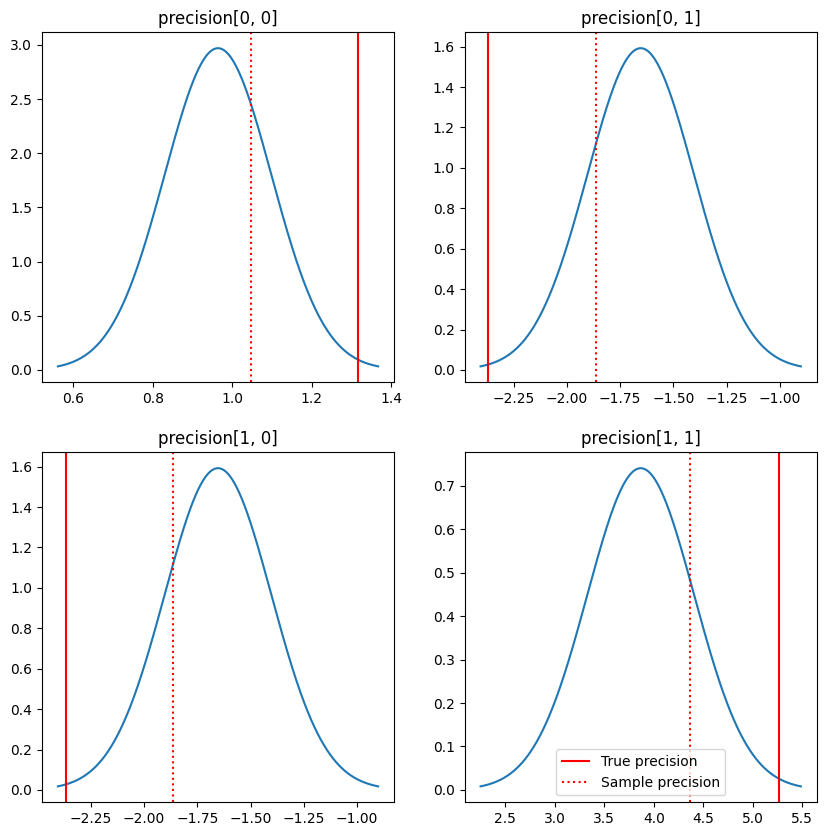

In [15]:
sample_precision = np.linalg.inv(np.cov(my_data, rowvar=False, bias=False))
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
for i in range(2):
  for j in range(2):
    ax = axes[i, j]
    loc = posterior_mean[i, j]
    scale = posterior_sd[i, j]
    xmin = loc - 3.0 * scale
    xmax = loc + 3.0 * scale
    x = np.linspace(xmin, xmax, 1000)
    y = scipy.stats.norm.pdf(x, loc=loc, scale=scale)
    ax.plot(x, y)
    ax.axvline(true_precision[i, j], color='red', label='True precision')
    ax.axvline(sample_precision[i, j], color='red', linestyle=':', label='Sample precision')
    ax.set_title('precision[%d, %d]' % (i, j))
plt.legend()
plt.show()

## Step 3: Implement the likelihood function in TensorFlow

Spoiler: Our first attempt isn't going to work; we'll talk about why below.

**Tip**: use TensorFlow eager mode when developing your likelihood functions.  Eager mode makes TF behave more like NumPy - everything executes immediately, so you can debug interactively instead of having to use `Session.run()`.  See the notes [here](https://www.tensorflow.org/programmers_guide/eager).

### Preliminary: Distribution classes

TFP has a collection of distribution classes that we'll use to generate our log probabilities.  One thing to note is that these classes work with tensors of samples rather than just single samples - this allows for vectorization and related speedups.

A distribution can work with a tensor of samples in 2 different ways.  It's simplest to illustrate these 2 ways with a concrete example involving a distribution with a single scalar parameter.  I'll use the [Poisson](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Poisson) distribution, which has a `rate` parameter. 
* If we create a Poisson with a single value for the `rate` parameter, a call to its `sample()` method return a single value.  This value is called an **`event`**, and in this case the events are all scalars.
* If we create a Poisson with a tensor of values for the `rate` parameter, a call to its `sample()`method now returns multiple values, one for each value in the rate tensor.  The object acts as a *collection* of independent Poissons, each with its own rate, and each of the values returned by a call to `sample()` corresponds to one of these Poissons.  This collection of independent *but not identically distributed* events is called a **`batch`**.
* The `sample()` method takes a `sample_shape` parameter which defaults to an empty tuple.  Passing a non-empty value for `sample_shape` results in sample returning multiple batches.  This collection of batches is called a **`sample`**.

A distribution's `log_prob()` method consumes data in a manner that parallels how `sample()` generates it.  `log_prob()` returns probabilities for samples, i.e. for multiple, independent batches of events.
  * If we have our Poisson object that was created with a scalar `rate`, each batch is a scalar, and if we pass in a tensor of samples, we'll get out a tensor of the same size of log probabilities.
  * If we have our Poisson object that was created with a tensor of shape `T` of `rate` values, each batch is a tensor of shape `T`.  If we pass in a tensor of samples of shape D, T, we'll get out a tensor of log probabilities of shape D, T.

Below are some examples that illustrate these cases.  See [this notebook](https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb) for a more detailed tutorial on events, batches, and shapes.


In [16]:
# case 1: get log probabilities for a vector of iid draws from a single
# normal distribution
norm1 = tfd.Normal(loc=0., scale=1.)
probs1 = norm1.log_prob(tf.constant([1., 0.5, 0.]))

# case 2: get log probabilities for a vector of independent draws from
# multiple normal distributions with different parameters.  Note the vector
# values for loc and scale in the Normal constructor.
norm2 = tfd.Normal(loc=[0., 2., 4.], scale=[1., 1., 1.])
probs2 = norm2.log_prob(tf.constant([1., 0.5, 0.]))

print('iid draws from a single normal:', probs1.numpy())
print('draws from a batch of normals:', probs2.numpy())

2023-08-13 12:04:29.956952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 12:04:29.958790: I tensorflow/c/logging.cc:34] DirectML: creating device on adapter 0 (NVIDIA GeForce GTX 1060 3GB)
2023-08-13 12:04:30.160100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-13 12:04:30.160146: W tensorflow/core/common_runtime/pluggable_device/pluggable_device_bfc_allocator.cc:28] Overriding allow_growth setting because force_memory_growth was requested by the device.
2023-08-13 12:04:30.160170: I tensorflow/core/common_runtime/pluggable_device/pluggable_devi

iid draws from a single normal: [-1.4189385 -1.0439385 -0.9189385]
draws from a batch of normals: [-1.4189385 -2.0439386 -8.918939 ]


### Data log likelihood

First we'll implement the data log likelihood function.

Note: distributions can validate their input, but they don't do so by default.  We'll definitely want to turn on validation while we're debugging!  Once everything is working, we can turn validation off if speed is really critical.

In [17]:
VALIDATE_ARGS = True
ALLOW_NAN_STATS = False

One key difference from the NumPy case is that our TensorFlow likelihood function will need to handle vectors of precision matrices rather than just single matrices.  Vectors of parameters will be used when we sample from multiple chains.

We'll create a distribution object that works with a batch of precision matrices (i.e. one matrix per chain).

When computing log probabilities of our data, we'll need our data to be replicated in the same manner as our parameters so that there is one copy per batch variable.  The shape of our replicated data will need to be as follows:

`[sample shape, batch shape, event shape]`

In our case, the event shape is 2 (since we are working with 2-D Gaussians).  The sample shape is 100, since we have 100 samples.  The batch shape will just be the number of precision matrices we're working with.  It's wasteful to replicate the data each time we call the likelihood function, so we'll replicate the data in advance and pass in the replicated version.

Note that this is an inefficient implementation: `MultivariateNormalFullCovariance` is expensive relative to some alternatives that we'll talk about in the optimization section at the end.

In [18]:
def log_lik_data(precisions, replicated_data):
  n = tf.shape(precisions)[0]  # number of precision matrices
  # We're estimating a precision matrix; we have to invert to get log
  # probabilities.  Cholesky inversion should be relatively efficient,
  # but as we'll see later, it's even better if we can avoid doing the Cholesky
  # decomposition altogether.
  precisions_cholesky = tf.linalg.cholesky(precisions)
  covariances = tf.linalg.cholesky_solve(
      precisions_cholesky, tf.linalg.eye(2, batch_shape=[n]))
  rv_data = tfd.MultivariateNormalFullCovariance(
      loc=tf.zeros([n, 2]),
      covariance_matrix=covariances,
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)

  return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [19]:
# For our test, we'll use a tensor of 2 precision matrices.
# We'll need to replicate our data for the likelihood function.
# Remember, TFP wants the data to be structured so that the sample dimensions
# are first (100 here), then the batch dimensions (2 here because we have 2
# precision matrices), then the event dimensions (2 because we have 2-D
# Gaussian data).  We'll need to add a middle dimension for the batch using
# expand_dims, and then we'll need to create 2 replicates in this new dimension
# using tile.
n = 2
replicated_data = np.tile(np.expand_dims(my_data, axis=1), reps=[1, 2, 1])
print(replicated_data.shape)

(100, 2, 2)


**Tip:**  One thing I've found to be extremely helpful is writing little sanity checks of my TensorFlow functions.  It's really easy to mess up the vectorization in TF, so having the simpler NumPy functions around is a great way to verify the TF output.  Think of these as little unit tests.

In [20]:
# check against the numpy implementation
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
n = precisions.shape[0]
lik_tf = log_lik_data(precisions, replicated_data=replicated_data).numpy()

for i in range(n):
  print(i)
  print('numpy:', log_lik_data_numpy(precisions[i], my_data))
  print('tensorflow:', lik_tf[i])

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


2023-08-13 12:04:30.516782: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-13 12:04:30.516862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17035 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


0
numpy: -430.71218815801365
tensorflow: -430.7122
1
numpy: -280.81822950593767
tensorflow: -280.81824


### Prior log likelihood

The prior is easier since we don't have to worry about data replication.

In [21]:
@tf.function(autograph=False)
def log_lik_prior(precisions):
  rv_precision = tfd.WishartTriL(
      df=PRIOR_DF,
      scale_tril=tf.linalg.cholesky(PRIOR_SCALE),
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)
  return rv_precision.log_prob(precisions)

In [22]:
# check against the numpy implementation
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
n = precisions.shape[0]
lik_tf = log_lik_prior(precisions).numpy()

for i in range(n):
  print(i)
  print('numpy:', log_lik_prior_numpy(precisions[i]))
  print('tensorflow:', lik_tf[i])

0
numpy: -2.2351873809649625
tensorflow: -2.2351875
1
numpy: -9.103606346649766
tensorflow: -9.103608


2023-08-13 12:04:33.484142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-13 12:04:33.507949: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: WishartTriL/assert_positive/assert_less/Assert/AssertGuard/branch_executed/_8


### Build the joint log likelihood function

The data log likelihood function above depends on our observations, but the sampler won't have those.  We can get rid of the dependency without using a global variable by using a [closure](https://en.wikipedia.org/wiki/Closure_(computer_programming).  Closures involve an outer function that build an environment containing variables needed by an inner function.

In [23]:
def get_log_lik(data, n_chains=1):
  # The data argument that is passed in will be available to the inner function
  # below so it doesn't have to be passed in as a parameter.
  replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])

  @tf.function(autograph=False)
  def _log_lik(precision):
    return log_lik_data(precision, replicated_data) + log_lik_prior(precision)

  return _log_lik

## Step 4: Sample

Ok, time to sample!  To keep things simple, we'll just use 1 chain and we'll use the identity matrix as the starting point.  We'll do things more carefully later.

Again, this isn't going to work - we'll get an exception.

In [24]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  init_precision = tf.expand_dims(tf.eye(2), axis=0)

  # Use expand_dims because we want to pass in a tensor of starting values
  log_lik_fn = get_log_lik(my_data, n_chains=1)

  # we'll just do a few steps here
  num_results = 10
  num_burnin_steps = 10
  states = tfp.mcmc.sample_chain(
     num_results=num_results,
     num_burnin_steps=num_burnin_steps,
     current_state=[
         init_precision,
     ],
     kernel=tfp.mcmc.HamiltonianMonteCarlo(
         target_log_prob_fn=log_lik_fn,
         step_size=0.1,
         num_leapfrog_steps=3),
     trace_fn=None,
     seed=123)
  return states

try:
  states = sample()
except Exception as e:
  # shorten the giant stack trace
  lines = str(e).split('\n')
  print('\n'.join(lines[:5]+['...']+lines[-3:]))

2023-08-13 12:04:34.615403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-13 12:04:34.903243: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: mcmc_sample_chain/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/StatefulPartitionedCall/StatefulPartitionedCall/WishartTriL/log_prob/assert_less_equal/Assert/AssertGuard/branch_executed/_358
2023-08-13 12:04:36.280100: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Graph execution error:

Detected at node 'MultivariateNormalFullCovariance/init/assert_near/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/home/kenny/miniconda3/envs/tfdml_plugin/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
...
	 [[{{node MultivariateNormalFullCovariance/init/assert_near/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_sample_1672]


### Identifying the problem

`InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.`  That's not super helpful.  Let's see if we can find out more about what happened.

* We'll print out the parameters for each step so we can see the value for which things fail
* We'll add some assertions to guard against specific problems.

Assertions are tricky because they're TensorFlow operations, and we have to take care that they get executed and don't get optimized out of the graph.  It's worth reading [this overview](https://wookayin.github.io/tensorflow-talk-debugging/#1) of TensorFlow debugging if you aren't familiar with TF assertions.  You can explicitly force assertions to execute using `tf.control_dependencies` (see the comments in the code below).

TensorFlow's native `Print` function has the same behavior as assertions - it's an operation, and you need to take some care to ensure that it executes.  `Print` causes additional headaches when we're working in a notebook: its output is sent to `stderr`, and `stderr` isn't displayed in the cell.  We'll use a trick here: instead of using `tf.Print`, we'll create our own TensorFlow print operation via `tf.pyfunc`.  As with assertions, we have to make sure our method executes.


In [25]:
def get_log_lik_verbose(data, n_chains=1):
  # The data argument that is passed in will be available to the inner function
  # below so it doesn't have to be passed in as a parameter.
  replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])

  def _log_lik(precisions):
    # An internal method we'll make into a TensorFlow operation via tf.py_func
    def _print_precisions(precisions):
      print('precisions:\n', precisions)
      return False  # operations must return something!
    # Turn our method into a TensorFlow operation
    print_op = tf.compat.v1.py_func(_print_precisions, [precisions], tf.bool)

    # Assertions are also operations, and some care needs to be taken to ensure
    # that they're executed
    assert_op = tf.assert_equal(
        precisions, tf.linalg.matrix_transpose(precisions),
        message='not symmetrical', summarize=4, name='symmetry_check')

    # The control_dependencies statement forces its arguments to be executed
    # before subsequent operations
    with tf.control_dependencies([print_op, assert_op]):
      return (log_lik_data(precisions, replicated_data) +
              log_lik_prior(precisions))

  return _log_lik

In [26]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  init_precision = tf.eye(2)[tf.newaxis, ...]
  log_lik_fn = get_log_lik_verbose(my_data)
  # we'll just do a few steps here
  num_results = 10
  num_burnin_steps = 10
  states = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          init_precision,
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=log_lik_fn,
          step_size=0.1,
          num_leapfrog_steps=3),
      trace_fn=None,
      seed=123)

try:
  states = sample()
except Exception as e:
  # shorten the giant stack trace
  lines = str(e).split('\n')
  print('\n'.join(lines[:5]+['...']+lines[-3:]))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


2023-08-13 12:04:37.563060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-13 12:04:37.913577: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: mcmc_sample_chain/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/symmetry_check_1/Assert/AssertGuard/branch_executed/_9


precisions:
 [[[1. 0.]
  [0. 1.]]]
precisions:
 [[[ 0.28876215 -0.503801  ]
  [-0.422474    1.0293131 ]]]
Graph execution error:

Detected at node 'mcmc_sample_chain/trace_scan/while/smart_for_loop/while/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/symmetry_check_1/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/home/kenny/miniconda3/envs/tfdml_plugin/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
...
	 [[{{node mcmc_sample_chain/trace_scan/while/smart_for_loop/while/mh_one_step/hmc_kernel_one_step/leapfrog_integrate/while/leapfrog_integrate_one_step/maybe_call_fn_and_grads/value_and_gradients/value_and_gradient/symmetry_check_1/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_sample_2993]


### Why this fails

The very first new parameter value the sampler tries is an asymmetrical matrix.  That causes the Cholesky decomposition to fail, since it's only defined for symmetrical (and positive definite) matrices.

The problem here is that our parameter of interest is a precision matrix, and precision matrices must be real, symmetric, and positive definite.  The sampler doesn't know anything about this constraint (except possibly through gradients), so it is entirely possible that the sampler will propose an invalid value, leading to an exception, particularly if the step size is large.

With the Hamiltonian Monte Carlo sampler, we may be able to work around the problem by using a very small step size, since the gradient should keep the parameters away from invalid regions, but small step sizes mean slow convergence.  With a Metropolis-Hastings sampler, which doesn't know anything about gradients, we're doomed.

# Version 2: reparametrizing to unconstrained parameters

There is a straightforward solution to the problem above: we can reparameterize our model such that the new parameters no longer have these constraints.  TFP provides a useful set of tools - bijectors - for doing just that.


### Reparameterization with bijectors

Our precision matrix must be real and symmetric; we want an alternative parameterization that doesn't have these constraints.  A starting point is a Cholesky factorization of the precision matrix.  The Cholesky factors are still constrained - they are lower triangular, and their diagonal elements must be positive.  However, if we take the log of the diagonals of the Cholesky factor, the logs are no longer constrained to be positive, and then if we flatten the lower triangular portion into a 1-D vector, we no longer have the lower triangular constraint.  The result in our case will be a length 3 vector with no constraints.

(The [Stan manual](http://mc-stan.org/users/documentation/) has a great chapter on using transformations to remove various types of constraints on parameters.)

This reparameterization has little effect on our data log likelihood function - we just have to invert our transformation so we get back the precision matrix - but the effect on the prior is more complicated.  We've specified that the probability of a given precision matrix is given by the Wishart distribution; what is the probability of our transformed matrix?

Recall that if we apply a monotonic function $g$ to a 1-D random variable $X$, $Y = g(X)$, the density for $Y$ is given by 

$$
f_Y(y) = | \frac{d}{dy}(g^{-1}(y)) | f_X(g^{-1}(y))
$$

The derivative of $g^{-1}$ term accounts for the way that $g$ changes local volumes.  For higher dimensional random variables, the corrective factor is the absolute value of the determinant of the Jacobian of $g^{-1}$ (see [here](https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables)).

We'll have to add a Jacobian of the inverse transform into our log prior likelihood function.  Happily, TFP's `Bijector` class can take care of this for us.


The [`Bijector`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector) class is used to represent invertible, smooth functions used for changing variables in probability density functions.  Bijectors all have a `forward()` method that performs a transform, an `inverse()` method that inverts it, and `forward_log_det_jacobian()` and `inverse_log_det_jacobian()` methods that provide the Jacobian corrections we need when we reparaterize a pdf.

TFP provides a collection of useful bijectors that we can combine through composition via the [`Chain`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Chain) operator to form quite complicated transforms.  In our case, we'll compose the following 3 bijectors (the operations in the chain are performed from right to left):

1. The first step of our transform is to perform a Cholesky factorization on the precision matrix.  There isn't a Bijector class for that; however, the [`CholeskyOuterProduct`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/CholeskyOuterProduct) bijector takes the product of 2 Cholesky factors.  We can use the inverse of that operation using the [`Invert`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Invert) operator.
2. The next step is to take the log of the diagonal elements of the Cholesky factor.  We accomplish this via the `TransformDiagonal` bijector and the inverse of the [`Exp`](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Exp) bijector.
3. Finally we flatten the lower triangular portion of the matrix to a vector using the inverse of the `FillTriangular` bijector.

In [27]:
# Our transform has 3 stages that we chain together via composition:
precision_to_unconstrained = tfb.Chain([
    # step 3: flatten the lower triangular portion of the matrix
    tfb.Invert(tfb.FillTriangular(validate_args=VALIDATE_ARGS)),
    # step 2: take the log of the diagonals    
    tfb.TransformDiagonal(tfb.Invert(tfb.Exp(validate_args=VALIDATE_ARGS))),
    # step 1: decompose the precision matrix into its Cholesky factors
    tfb.Invert(tfb.CholeskyOuterProduct(validate_args=VALIDATE_ARGS)),
])

In [28]:
# sanity checks
m = tf.constant([[1., 2.], [2., 8.]])
m_fwd = precision_to_unconstrained.forward(m)
m_inv = precision_to_unconstrained.inverse(m_fwd)

# bijectors handle tensors of values, too!
m2 = tf.stack([m, tf.eye(2)])
m2_fwd = precision_to_unconstrained.forward(m2)
m2_inv = precision_to_unconstrained.inverse(m2_fwd)

print('single input:')
print('m:\n', m.numpy())
print('precision_to_unconstrained(m):\n', m_fwd.numpy())
print('inverse(precision_to_unconstrained(m)):\n', m_inv.numpy())
print()

print('tensor of inputs:')
print('m2:\n', m2.numpy())
print('precision_to_unconstrained(m2):\n', m2_fwd.numpy())
print('inverse(precision_to_unconstrained(m2)):\n', m2_inv.numpy())

single input:
m:
 [[1. 2.]
 [2. 8.]]
precision_to_unconstrained(m):
 [0.6931472 2.        0.       ]
inverse(precision_to_unconstrained(m)):
 [[1. 2.]
 [2. 8.]]

tensor of inputs:
m2:
 [[[1. 2.]
  [2. 8.]]

 [[1. 0.]
  [0. 1.]]]
precision_to_unconstrained(m2):
 [[0.6931472 2.        0.       ]
 [0.        0.        0.       ]]
inverse(precision_to_unconstrained(m2)):
 [[[1. 2.]
  [2. 8.]]

 [[1. 0.]
  [0. 1.]]]


The [`TransformedDistribution`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/TransformedDistribution) class automates the process of applying a bijector to a distribution and making the necessary Jacobian correction to `log_prob()`.  Our new prior becomes:

In [29]:
def log_lik_prior_transformed(transformed_precisions):
  rv_precision = tfd.TransformedDistribution(
      tfd.WishartTriL(
          df=PRIOR_DF,
          scale_tril=tf.linalg.cholesky(PRIOR_SCALE),
          validate_args=VALIDATE_ARGS,
          allow_nan_stats=ALLOW_NAN_STATS),
      bijector=precision_to_unconstrained,
      validate_args=VALIDATE_ARGS)
  return rv_precision.log_prob(transformed_precisions)

In [ ]:
# Check against the numpy implementation.  Note that when comparing, we need
# to add in the Jacobian correction.
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
transformed_precisions = precision_to_unconstrained.forward(precisions)
lik_tf = log_lik_prior_transformed(transformed_precisions).numpy()
corrections = precision_to_unconstrained.inverse_log_det_jacobian(
    transformed_precisions, event_ndims=1).numpy()
n = precisions.shape[0]

for i in range(n):
  print(i)
  print('numpy:', log_lik_prior_numpy(precisions[i]) + corrections[i])
  print('tensorflow:', lik_tf[i])

2023-08-13 12:04:38.779040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-13 12:04:38.779109: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17035 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2023-08-13 12:04:38.792215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-13 12:04:38.792287: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17035 MB memory) -> physical PluggableDevice (device: 0, name: 

: 

: 

We just need to invert the transform for our data log likelihood:

`precision = precision_to_unconstrained.inverse(transformed_precision)
`

Since we actually want the Cholesky factorization of the precision matrix, it would be more efficient to do just a partial inverse here.  However, we'll leave optimization for later and will leave the partial inverse as an exercise for the reader.

In [ ]:
def log_lik_data_transformed(transformed_precisions, replicated_data):
  # We recover the precision matrix by inverting our bijector.  This is
  # inefficient since we really want the Cholesky decomposition of the
  # precision matrix, and the bijector has that in hand during the inversion,
  # but we'll worry about efficiency later.
  n = tf.shape(transformed_precisions)[0]
  precisions = precision_to_unconstrained.inverse(transformed_precisions)
  precisions_cholesky = tf.linalg.cholesky(precisions)
  covariances = tf.linalg.cholesky_solve(
      precisions_cholesky, tf.linalg.eye(2, batch_shape=[n]))
  rv_data = tfd.MultivariateNormalFullCovariance(
      loc=tf.zeros([n, 2]),
      covariance_matrix=covariances,
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)

  return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [ ]:
# sanity check
precisions = np.stack([np.eye(2, dtype=np.float32), true_precision])
transformed_precisions = precision_to_unconstrained.forward(precisions)
lik_tf = log_lik_data_transformed(
    transformed_precisions, replicated_data).numpy()

for i in range(precisions.shape[0]):
  print(i)
  print('numpy:', log_lik_data_numpy(precisions[i], my_data))
  print('tensorflow:', lik_tf[i])

0
numpy: -430.71218815801365
tensorflow: -430.71207
1
numpy: -280.81822950593767
tensorflow: -280.8182


Again we wrap our new functions in a closure.

In [ ]:
def get_log_lik_transformed(data, n_chains=1):
  # The data argument that is passed in will be available to the inner function
  # below so it doesn't have to be passed in as a parameter.
  replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])

  @tf.function(autograph=False)
  def _log_lik_transformed(transformed_precisions):
    return (log_lik_data_transformed(transformed_precisions, replicated_data) +
            log_lik_prior_transformed(transformed_precisions))

  return _log_lik_transformed

In [ ]:
# make sure everything runs
log_lik_fn = get_log_lik_transformed(my_data)
m = tf.eye(2)[tf.newaxis, ...]
lik = log_lik_fn(precision_to_unconstrained.forward(m)).numpy()
print(lik)

[-431.5611]


## Sampling

Now that we don't have to worry about our sampler blowing up because of invalid parameter values, let's generate some real samples.

The sampler works with the unconstrained version of our parameters, so we need to transform our initial value to its unconstrained version.  The samples that we generate will also all be in their unconstrained form, so we need to transform them back.  Bijectors are vectorized, so it's easy to do so.

In [ ]:
# We'll choose a proper random initial value this time
np.random.seed(123)
initial_value_cholesky = np.array(
    [[0.5 + np.random.uniform(), 0.0],
     [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]],
    dtype=np.float32)
initial_value =  initial_value_cholesky.dot(
  initial_value_cholesky.T)[np.newaxis, ...]

# The sampler works with unconstrained values, so we'll transform our initial
# value
initial_value_transformed = precision_to_unconstrained.forward(
  initial_value).numpy()

In [ ]:
# Sample!
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  log_lik_fn = get_log_lik_transformed(my_data, n_chains=1)

  num_results = 1000
  num_burnin_steps = 1000

  states, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          initial_value_transformed,
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=log_lik_fn,
          step_size=0.1,
          num_leapfrog_steps=3),
      trace_fn=lambda _, pkr: pkr.is_accepted,
      seed=123)
  # transform samples back to their constrained form
  precision_samples = [precision_to_unconstrained.inverse(s) for s in states]
  return states, precision_samples, is_accepted

states, precision_samples, is_accepted = sample()

Let's compare the mean of our sampler's output to the analytic posterior mean!

In [ ]:
print('True posterior mean:\n', posterior_mean)
print('Sample mean:\n', np.mean(np.reshape(precision_samples, [-1, 2, 2]), axis=0))

True posterior mean:
 [[ 0.9641779 -1.6534661]
 [-1.6534661  3.8683164]]
Sample mean:
 [[ 1.4315274  -0.25587553]
 [-0.25587553  0.5740424 ]]


We're way off!  Let's figure out why.  First let's look at our samples.

In [ ]:
np.reshape(precision_samples, [-1, 2, 2])

array([[[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       ...,

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]],

       [[ 1.4315385, -0.2558777],
        [-0.2558777,  0.5740494]]], dtype=float32)

Uh oh - it looks like they all have the same value.  Let's figure out why.

The `kernel_results_` variable is a named tuple that gives information about the sampler at each state.  The `is_accepted` field is the key here.

In [ ]:
# Look at the acceptance for the last 100 samples
print(np.squeeze(is_accepted)[-100:])
print('Fraction of samples accepted:', np.mean(np.squeeze(is_accepted)))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Fraction of samples accepted: 0.0


All our samples were rejected!  Presumably our step size was too big.  I chose `stepsize=0.1` purely arbitrarily.


# Version 3: sampling with an adaptive step size

Since sampling with my arbitrary choice of step size failed, we have a few agenda items:
1. implement an adaptive step size, and
2. perform some convergence checks.

There is some nice sample code in `tensorflow_probability/python/mcmc/hmc.py` for implementing adaptive step sizes.  I've adapted it below.

Note that there's a separate `sess.run()` statement for each step.  This is really helpful for debugging, since it allows us to easily add some per-step diagnostics if need be.  For example, we can show incremental progress, time each step, etc.

**Tip:** One apparently common way to mess up your sampling is to have your graph grow in the loop.  (The reason for finalizing the graph before the session is run is to prevent just such problems.)  If you haven't been using finalize(), though, a useful debugging check if your code slows to a crawl is to print out the graph size at each step via `len(mygraph.get_operations())` - if the length increases, you're probably doing something bad.

We're going to run 3 independent chains here.  Doing some comparisons between the chains will help us check for convergence.

In [ ]:
# The number of chains is determined by the shape of the initial values.
# Here we'll generate 3 chains, so we'll need a tensor of 3 initial values.
N_CHAINS = 3

np.random.seed(123)

initial_values = []
for i in range(N_CHAINS):
  initial_value_cholesky = np.array(
      [[0.5 + np.random.uniform(), 0.0],
       [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]],
      dtype=np.float32)
  initial_values.append(initial_value_cholesky.dot(initial_value_cholesky.T))
initial_values = np.stack(initial_values)

initial_values_transformed = precision_to_unconstrained.forward(
  initial_values).numpy()

In [ ]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  log_lik_fn = get_log_lik_transformed(my_data)

  # Tuning acceptance rates:
  dtype = np.float32
  num_burnin_iter = 3000
  num_warmup_iter = int(0.8 * num_burnin_iter) 
  num_chain_iter = 2500

  # Set the target average acceptance ratio for the HMC as suggested by
  # Beskos et al. (2013):
  # https://projecteuclid.org/download/pdfview_1/euclid.bj/1383661192
  target_accept_rate = 0.651

  # Initialize the HMC sampler.
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=log_lik_fn,
      step_size=0.01,
      num_leapfrog_steps=3)

  # Adapt the step size using standard adaptive MCMC procedure. See Section 4.2
  # of Andrieu and Thoms (2008):
  # http://www4.ncsu.edu/~rsmith/MA797V_S12/Andrieu08_AdaptiveMCMC_Tutorial.pdf
  adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=hmc,
      num_adaptation_steps=num_warmup_iter,
      target_accept_prob=target_accept_rate)

  states, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_chain_iter,
      num_burnin_steps=num_burnin_iter,
      current_state=initial_values_transformed,
      kernel=adapted_kernel,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
      parallel_iterations=1)
  # transform samples back to their constrained form
  precision_samples = precision_to_unconstrained.inverse(states)
  return states, precision_samples, is_accepted

states, precision_samples, is_accepted = sample() 

A quick check: our acceptance rate during our sampling is close to our target of 0.651.

In [ ]:
print(np.mean(is_accepted))

0.6190666666666667


Even better, our sample mean and standard deviation are close to what we expect from the analytic solution.

In [ ]:
precision_samples_reshaped = np.reshape(precision_samples, [-1, 2, 2])
print('True posterior mean:\n', posterior_mean)
print('Mean of samples:\n', np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 0.9641779 -1.6534661]
 [-1.6534661  3.8683164]]
Mean of samples:
 [[ 0.96426415 -1.6519215 ]
 [-1.6519215   3.8614824 ]]


In [ ]:
print('True posterior standard deviation:\n', posterior_sd)
print('Standard deviation of samples:\n', np.std(precision_samples_reshaped, axis=0))

True posterior standard deviation:
 [[0.13435492 0.25050813]
 [0.25050813 0.53903675]]
Standard deviation of samples:
 [[0.13622096 0.25235635]
 [0.25235635 0.5394968 ]]


## Checking for convergence

In general we won't have an analytic solution to check against, so we'll need to make sure the sampler has converged.  One standard check is the Gelman-Rubin $\hat{R}$ statistic, which requires multiple sampling chains.  $\hat{R}$ measures the degree to which variance (of the means) between chains exceeds what one would expect if the chains were identically distributed.  Values of $\hat{R}$ close to 1 are used to indicate approximate convergence.  See [the source](https://github.com/tensorflow/probability/blob/main/tensorflow_probability/python/mcmc/diagnostic.py#L205) for details.

In [ ]:
r_hat = tfp.mcmc.potential_scale_reduction(precision_samples).numpy()
print(r_hat)

[[1.0038308 1.0005717]
 [1.0005717 1.0006068]]


## Model criticism

If we didn't have an analytic solution, this would be the time to do some real model criticism.

Here are a few quick histograms of the sample components relative to our ground truth (in red).  Note that the samples have been shrunk from the sample precision matrix values toward the identity matrix prior.

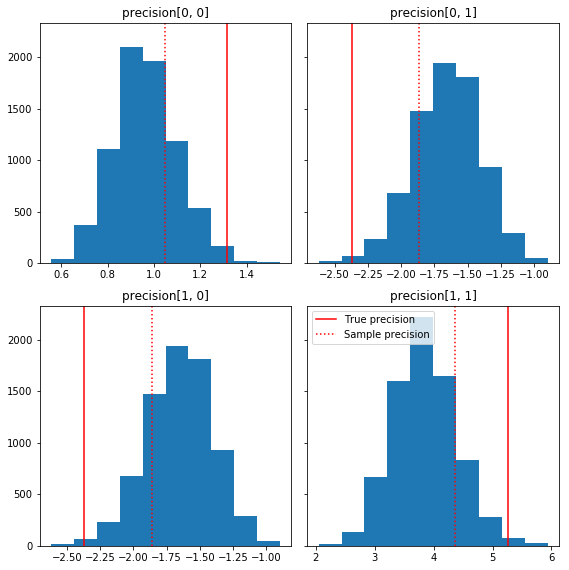

In [ ]:
fig, axes = plt.subplots(2, 2, sharey=True)
fig.set_size_inches(8, 8)
for i in range(2):
  for j in range(2):
    ax = axes[i, j]
    ax.hist(precision_samples_reshaped[:, i, j])
    ax.axvline(true_precision[i, j], color='red',
               label='True precision')
    ax.axvline(sample_precision[i, j], color='red', linestyle=':',
               label='Sample precision')
    ax.set_title('precision[%d, %d]' % (i, j))
plt.tight_layout()
plt.legend()
plt.show()

Some scatterplots of pairs of precision components show that because of the correlation structure of the posterior, the true posterior values are not as unlikely as they appear from the marginals above.

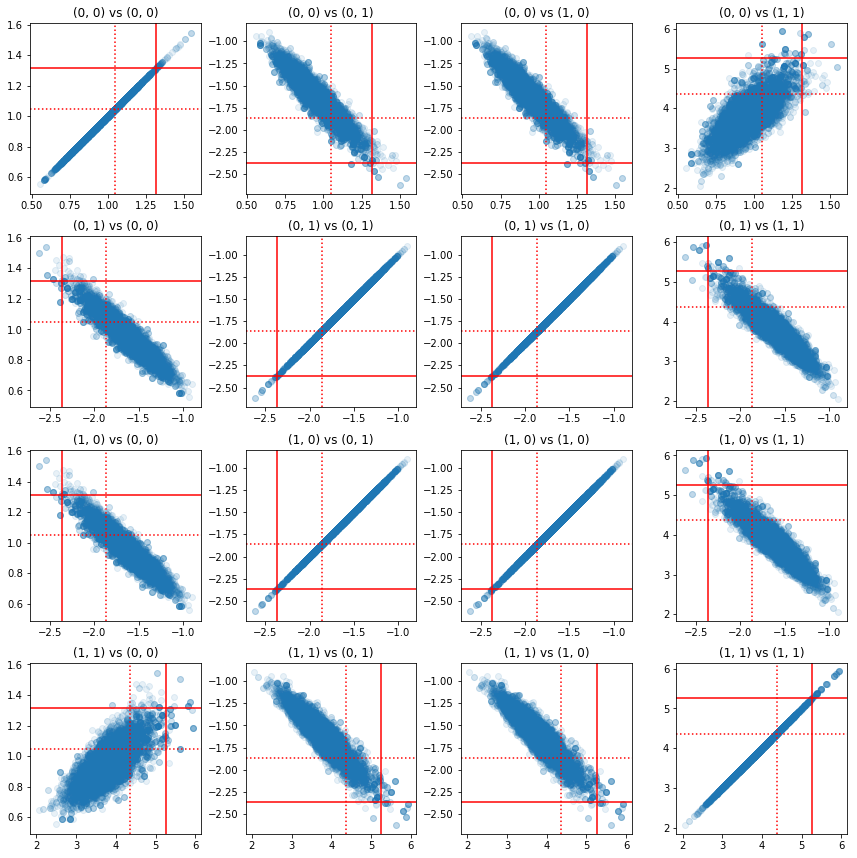

In [ ]:
fig, axes = plt.subplots(4, 4)
fig.set_size_inches(12, 12)
for i1 in range(2):
  for j1 in range(2):
    index1 = 2 * i1 + j1
    for i2 in range(2):
      for j2 in range(2):
        index2 = 2 * i2 + j2
        ax = axes[index1, index2]
        ax.scatter(precision_samples_reshaped[:, i1, j1],
                   precision_samples_reshaped[:, i2, j2], alpha=0.1)
        ax.axvline(true_precision[i1, j1], color='red')
        ax.axhline(true_precision[i2, j2], color='red')
        ax.axvline(sample_precision[i1, j1], color='red', linestyle=':')
        ax.axhline(sample_precision[i2, j2], color='red', linestyle=':')
        ax.set_title('(%d, %d) vs (%d, %d)' % (i1, j1, i2, j2))
plt.tight_layout()
plt.show()

# Version 4: simpler sampling of constrained parameters

Bijectors made sampling the precision matrix straightforward, but there was a fair amount of manual converting to and from the unconstrained representation.  There is an easier way!

### The TransformedTransitionKernel

The `TransformedTransitionKernel` simplifies this process.  It wraps your sampler and handles all the conversions.  It takes as an argument a list of bijectors that map unconstrained parameter values to constrained ones.  So here we need the inverse of the `precision_to_unconstrained` bijector we used above.  We could just use `tfb.Invert(precision_to_unconstrained)`, but that would involve taking of inverses of inverses (TensorFlow isn't smart enough to simplify `tf.Invert(tf.Invert())` to `tf.Identity())`, so instead we'll just write a new bijector.

### Constraining bijector

In [ ]:
# The bijector we need for the TransformedTransitionKernel is the inverse of
# the one we used above
unconstrained_to_precision = tfb.Chain([
    # step 3: take the product of Cholesky factors
    tfb.CholeskyOuterProduct(validate_args=VALIDATE_ARGS),
    # step 2: exponentiate the diagonals    
    tfb.TransformDiagonal(tfb.Exp(validate_args=VALIDATE_ARGS)),
    # step 1: map a vector to a lower triangular matrix
    tfb.FillTriangular(validate_args=VALIDATE_ARGS),
])

In [ ]:
# quick sanity check
m = [[1., 2.], [2., 8.]]
m_inv = unconstrained_to_precision.inverse(m).numpy()
m_fwd = unconstrained_to_precision.forward(m_inv).numpy()

print('m:\n', m)
print('unconstrained_to_precision.inverse(m):\n', m_inv)
print('forward(unconstrained_to_precision.inverse(m)):\n', m_fwd)

m:
 [[1.0, 2.0], [2.0, 8.0]]
unconstrained_to_precision.inverse(m):
 [0.6931472 2.        0.       ]
forward(unconstrained_to_precision.inverse(m)):
 [[1. 2.]
 [2. 8.]]


## Sampling with the TransformedTransitionKernel

With the `TransformedTransitionKernel`, we no longer have to do manual transformations of our parameters.  Our initial values and our samples are all precision matrices; we just have to pass in our unconstraining bijector(s) to the kernel and it takes care of all the transformations.

In [ ]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  log_lik_fn = get_log_lik(my_data)

  # Tuning acceptance rates:
  dtype = np.float32
  num_burnin_iter = 3000
  num_warmup_iter = int(0.8 * num_burnin_iter) 
  num_chain_iter = 2500

  # Set the target average acceptance ratio for the HMC as suggested by
  # Beskos et al. (2013):
  # https://projecteuclid.org/download/pdfview_1/euclid.bj/1383661192
  target_accept_rate = 0.651

  # Initialize the HMC sampler.
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=log_lik_fn,
      step_size=0.01,
      num_leapfrog_steps=3)

  ttk = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstrained_to_precision)

  # Adapt the step size using standard adaptive MCMC procedure. See Section 4.2
  # of Andrieu and Thoms (2008):
  # http://www4.ncsu.edu/~rsmith/MA797V_S12/Andrieu08_AdaptiveMCMC_Tutorial.pdf
  adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=ttk,
      num_adaptation_steps=num_warmup_iter,
      target_accept_prob=target_accept_rate)

  states = tfp.mcmc.sample_chain(
      num_results=num_chain_iter,
      num_burnin_steps=num_burnin_iter,
      current_state=initial_values,
      kernel=adapted_kernel,
      trace_fn=None,
      parallel_iterations=1)
  # transform samples back to their constrained form
  return states

precision_samples  = sample()

### Checking convergence

The $\hat{R}$ convergence check looks good!

In [ ]:
r_hat = tfp.mcmc.potential_scale_reduction(precision_samples).numpy()
print(r_hat)

[[1.0013582 1.0019467]
 [1.0019467 1.0011805]]


### Comparison against the analytic posterior

Again let's check against the analytic posterior.

In [ ]:
# The output samples have shape [n_steps, n_chains, 2, 2]
# Flatten them to [n_steps * n_chains, 2, 2] via reshape:
precision_samples_reshaped = np.reshape(precision_samples, [-1, 2, 2])

In [ ]:
print('True posterior mean:\n', posterior_mean)
print('Mean of samples:\n', np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 0.9641779 -1.6534661]
 [-1.6534661  3.8683164]]
Mean of samples:
 [[ 0.96687526 -1.6552585 ]
 [-1.6552585   3.867676  ]]


In [ ]:
print('True posterior standard deviation:\n', posterior_sd)
print('Standard deviation of samples:\n', np.std(precision_samples_reshaped, axis=0))

True posterior standard deviation:
 [[0.13435492 0.25050813]
 [0.25050813 0.53903675]]
Standard deviation of samples:
 [[0.13329624 0.24913791]
 [0.24913791 0.53983927]]


# Optimizations

Now that we've got things running end-to-end, let's do a more optimized version.  Speed doesn't matter too much for this example, but once matrices get larger, a few optimizations will make a big difference.

One big speed improvement we can make is to reparameterize in terms of the Cholesky decomposition.  The reason is our data likelihood function requires both the covariance and the precision matrices.  Matrix inversion is expensive ($O(n^3)$ for an $n \times n$ matrix), and if we parameterize in terms of either the covariance or the precision matrix, we need to do an inversion to get the other.

As a reminder, a real, positive-definite, symmetric matrix $M$ can be decomposed into a product of the form $M = L L^T$ where the matrix $L$ is lower triangular and has positive diagonals.  Given the Cholesky decomposition of $M$, we can more efficiently obtain both $M$ (the product of a lower and an upper triangular matrix) and $M^{-1}$ (via back-substitution).  The Cholesky factorization itself is not cheap to compute, but if we parameterize in terms of Cholesky factors, we only need to compute the Choleksy factorization of the initial parameter values.


## Using the Cholesky decomposition of the covariance matrix

TFP has a version of the multivariate normal distribution, [MultivariateNormalTriL](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalTriL), that is parameterized in terms of the Cholesky factor of the covariance matrix.  So if we were to parameterize in terms of the Cholesky factor of the covariance matrix, we could compute the data log likelihood efficiently.  The challenge is in computing the prior log likelihood with similar efficiency.

If we had a version of the inverse Wishart distribution that worked with Cholesky factors of samples, we'd be all set.  Alas, we don't.  (The team would welcome code submissions, though!)  As an alternative, we can use a version of the Wishart distribution that works with Cholesky factors of samples together with a chain of bijectors.

At the moment, we're missing a few stock bijectors to make things really efficient, but I want to show the process as an exercise and a useful illustration of the power of TFP's bijectors.

### A Wishart distribution that operates on Cholesky factors

The `Wishart` distribution has a useful flag, `input_output_cholesky`, that specifies that the input and output matrices should be Cholesky factors.  It's more efficient and numerically advantageous to work with the Cholesky factors than full matrices, which is why this is desirable.  An important point about the semantics of the flag: it's only an indication that the representation of the input and output to the distribution should change - it does *not* indicate a full reparameterization of the distribution, which would involve a Jacobian correction to the `log_prob()` function.  We actually want to do this full reparameterization, so we'll build our own distribution.

In [ ]:
# An optimized Wishart distribution that has been transformed to operate on
# Cholesky factors instead of full matrices.  Note that we gain a modest
# additional speedup by specifying the Cholesky factor of the scale matrix
# (i.e. by passing in the scale_tril parameter instead of scale).

class CholeskyWishart(tfd.TransformedDistribution):
  """Wishart distribution reparameterized to use Cholesky factors."""
  def __init__(self,
      df,
      scale_tril,
      validate_args=False,
      allow_nan_stats=True,
      name='CholeskyWishart'):
    # Wishart has a bunch of methods that we want to support but not
    # implement.  We'll subclass TransformedDistribution here to take care of
    # those.  We'll override the few for which speed is critical and implement
    # them with a separate Wishart for which input_output_cholesky=True
    super(CholeskyWishart, self).__init__(
        distribution=tfd.WishartTriL(
            df=df,
            scale_tril=scale_tril,
            input_output_cholesky=False,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats),
        bijector=tfb.Invert(tfb.CholeskyOuterProduct()),
        validate_args=validate_args,
        name=name
    )
    # Here's the Cholesky distribution we'll use for log_prob() and sample()
    self.cholesky = tfd.WishartTriL(
        df=df,
        scale_tril=scale_tril,
        input_output_cholesky=True,
        validate_args=validate_args,
        allow_nan_stats=allow_nan_stats)
    
  def _log_prob(self, x):
    return (self.cholesky.log_prob(x) +
            self.bijector.inverse_log_det_jacobian(x, event_ndims=2))

  def _sample_n(self, n, seed=None):
    return self.cholesky._sample_n(n, seed)

In [ ]:
# some checks
PRIOR_SCALE_CHOLESKY = np.linalg.cholesky(PRIOR_SCALE)

@tf.function(autograph=False)
def compute_log_prob(m):
  w_transformed = tfd.TransformedDistribution(
      tfd.WishartTriL(df=PRIOR_DF, scale_tril=PRIOR_SCALE_CHOLESKY),
      bijector=tfb.Invert(tfb.CholeskyOuterProduct()))
  w_optimized = CholeskyWishart(
      df=PRIOR_DF, scale_tril=PRIOR_SCALE_CHOLESKY)
  log_prob_transformed = w_transformed.log_prob(m)
  log_prob_optimized = w_optimized.log_prob(m)
  return log_prob_transformed, log_prob_optimized

for matrix in [np.eye(2, dtype=np.float32),
               np.array([[1., 0.], [2., 8.]], dtype=np.float32)]:
  log_prob_transformed, log_prob_optimized = [
      t.numpy() for t in compute_log_prob(matrix)]
  print('Transformed Wishart:', log_prob_transformed)
  print('Optimized Wishart', log_prob_optimized)

Transformed Wishart: -0.84889317
Optimized Wishart -0.84889317
Transformed Wishart: -99.269455
Optimized Wishart -99.269455


### Building an inverse Wishart distribution

We have our covariance matrix $C$ decomposed into $C = L L^T$ where $L$ is lower triangular and has a positive diagonal.  We want to know the probability of $L$ given that $C \sim W^{-1}(\nu, V)$ where $W^{-1}$ is the inverse Wishart distribution.

The inverse Wishart distribution has the property that if $C \sim W^{-1}(\nu, V)$, then the precision matrix $C^{-1} \sim W(\nu, V^{-1})$.  So we can get the probability of $L$ via a `TransformedDistribution` that takes as parameters the Wishart distribution and a bijector that maps the Cholesky factor of precision matrix to a Cholesky factor of its inverse.

A straightforward (but not super efficient) way to get from the Cholesky factor of $C^{-1}$ to $L$ is to invert the Cholesky factor by back-solving, then forming the covariance matrix from these inverted factors, and then doing a Cholesky factorization.

Let the Cholesky decomposition of $C^{-1} = M M^T$.  $M$ is lower triangular, so we can invert it using the `MatrixInverseTriL` bijector.

Forming $C$ from $M^{-1}$ is a little tricky: $C = (M M^T)^{-1} = M^{-T}M^{-1} = M^{-T} (M^{-T})^T$.  $M$ is lower triangular, so $M^{-1}$ will also be lower triangular, and $M^{-T}$ will be upper triangular.  The `CholeskyOuterProduct()` bijector only works with lower triangular matrices, so we can't use it to form $C$ from $M^{-T}$.  Our workaround is a chain of bijectors that permute the rows and columns of a matrix.

Luckily this logic is encapsulated in the `CholeskyToInvCholesky` bijector!

### Combining all the pieces

In [ ]:
# verify that the bijector works
m = np.array([[1., 0.], [2., 8.]], dtype=np.float32)
c_inv = m.dot(m.T)
c = np.linalg.inv(c_inv)
c_chol = np.linalg.cholesky(c)
wishart_cholesky_to_iw_cholesky = tfb.CholeskyToInvCholesky()
w_fwd = wishart_cholesky_to_iw_cholesky.forward(m).numpy()

print('numpy =\n', c_chol)
print('bijector =\n', w_fwd)

numpy =
 [[ 1.0307764   0.        ]
 [-0.03031695  0.12126781]]
bijector =
 [[ 1.0307764   0.        ]
 [-0.03031695  0.12126781]]


### Our final distribution

Our inverse Wishart operating on Cholesky factors is as follows:


In [ ]:
inverse_wishart_cholesky = tfd.TransformedDistribution(
    distribution=CholeskyWishart(
        df=PRIOR_DF,
        scale_tril=np.linalg.cholesky(np.linalg.inv(PRIOR_SCALE))),
    bijector=tfb.CholeskyToInvCholesky())

We've got our inverse Wishart, but it's kind of slow because we have to do a Cholesky decomposition in the bijector.  Let's return to the precision matrix parameterization and see what we can do there for optimization.

# Final(!) Version: using the Cholesky decomposition of the precision matrix

An alternative approach is to work with Cholesky factors of the precision matrix.  Here the prior likelihood function is easy to compute, but the data log likelihood function takes more work since TFP doesn't have a version of the multivariate normal that is parameterized by precision.

### Optimized prior log likelihood

We use the `CholeskyWishart` distribution we built above to construct the prior.


In [ ]:
# Our new prior.
PRIOR_SCALE_CHOLESKY = np.linalg.cholesky(PRIOR_SCALE)

def log_lik_prior_cholesky(precisions_cholesky):
  rv_precision = CholeskyWishart(
      df=PRIOR_DF,
      scale_tril=PRIOR_SCALE_CHOLESKY,
      validate_args=VALIDATE_ARGS,
      allow_nan_stats=ALLOW_NAN_STATS)
  return rv_precision.log_prob(precisions_cholesky)

In [ ]:
# Check against the slower TF implementation and the NumPy implementation.
# Note that when comparing to NumPy, we need to add in the Jacobian correction.
precisions = [np.eye(2, dtype=np.float32),
              true_precision]
precisions_cholesky = np.stack([np.linalg.cholesky(m) for m in precisions])
precisions = np.stack(precisions)
lik_tf = log_lik_prior_cholesky(precisions_cholesky).numpy()
lik_tf_slow = tfd.TransformedDistribution(
    distribution=tfd.WishartTriL(
        df=PRIOR_DF, scale_tril=tf.linalg.cholesky(PRIOR_SCALE)),
    bijector=tfb.Invert(tfb.CholeskyOuterProduct())).log_prob(
    precisions_cholesky).numpy()
corrections = tfb.Invert(tfb.CholeskyOuterProduct()).inverse_log_det_jacobian(
    precisions_cholesky, event_ndims=2).numpy()
n = precisions.shape[0]

for i in range(n):
  print(i)
  print('numpy:', log_lik_prior_numpy(precisions[i]) + corrections[i])
  print('tensorflow slow:', lik_tf_slow[i])
  print('tensorflow fast:', lik_tf[i])

0
numpy: -0.8488930160357633
tensorflow slow: -0.84889317
tensorflow fast: -0.84889317
1
numpy: -7.442875031036973
tensorflow slow: -7.442877
tensorflow fast: -7.442876


### Optimized data log likelihood

We can use TFP's bijectors to build our own version of the multivariate normal.  Here is the key idea:

Suppose I have a column vector $X$ whose elements are iid samples of $N(0, 1)$.  We have $\text{mean}(X) = 0$ and $\text{cov}(X) = I$

Now let $Y = A X + b$.  We have $\text{mean}(Y) = b$ and $\text{cov}(Y) = A A^T$

Hence we can make vectors with mean $b$ and covariance $C$ using the affine transform $Ax+b$ to vectors of iid standard Normal samples provided $A A^T = C$.  The Cholesky decomposition of $C$ has the desired property.  However, there are other solutions.

Let $P = C^{-1}$ and let the Cholesky decomposition of $P$ be $B$, i.e. $B B^T = P$.  Now

$P^{-1} = (B B^T)^{-1} = B^{-T} B^{-1} = B^{-T} (B^{-T})^T$

So another way to get our desired mean and covariance is to use the affine transform $Y=B^{-T}X + b$.

Our approach (courtesy of [this notebook](https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb)):
1. Use `tfd.Independent()` to combine a batch of 1-D `Normal` random variables into a single multi-dimensional random variable. The `reinterpreted_batch_ndims` parameter for `Independent()` specifies the number of batch dimensions that should be reinterpreted as event dimensions.  In our case we create a 1-D batch of length 2 that we transform into a 1-D event of length 2, so `reinterpreted_batch_ndims=1`.
2. Apply a bijector to add the desired covariance: `tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=precision_cholesky, adjoint=True))`.  Note that above we're multiplying our iid normal random variables by the transpose of the inverse of the Cholesky factor of the precision matrix $(B^{-T}X)$.  The `tfb.Invert` takes care of inverting $B$, and the `adjoint=True` flag performs the transpose.
3. Apply a bijector to add the desired offset: `tfb.Shift(shift=shift)`  Note that we have to do the shift as a separate step from the initial inverted affine transform because otherwise the inverted scale is applied to the shift (since the inverse of $y=Ax+b$ is $x=A^{-1}y - A^{-1}b$).


In [ ]:
class MVNPrecisionCholesky(tfd.TransformedDistribution):
  """Multivariate normal parameterized by loc and Cholesky precision matrix."""

  def __init__(self, loc, precision_cholesky, name=None):
    super(MVNPrecisionCholesky, self).__init__(
        distribution=tfd.Independent(
            tfd.Normal(loc=tf.zeros_like(loc),
                       scale=tf.ones_like(loc)),
            reinterpreted_batch_ndims=1),
        bijector=tfb.Chain([
            tfb.Shift(shift=loc),
            tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=precision_cholesky,
                                  adjoint=True)),
        ]),
        name=name)

In [ ]:
@tf.function(autograph=False)
def log_lik_data_cholesky(precisions_cholesky, replicated_data):
  n = tf.shape(precisions_cholesky)[0]  # number of precision matrices
  rv_data = MVNPrecisionCholesky(
      loc=tf.zeros([n, 2]),
      precision_cholesky=precisions_cholesky)
  return tf.reduce_sum(rv_data.log_prob(replicated_data), axis=0)

In [ ]:
# check against the numpy implementation
true_precision_cholesky = np.linalg.cholesky(true_precision)
precisions = [np.eye(2, dtype=np.float32), true_precision]
precisions_cholesky = np.stack([np.linalg.cholesky(m) for m in precisions])
precisions = np.stack(precisions)
n = precisions_cholesky.shape[0]
replicated_data = np.tile(np.expand_dims(my_data, axis=1), reps=[1, 2, 1])
lik_tf = log_lik_data_cholesky(precisions_cholesky, replicated_data).numpy()

for i in range(n):
  print(i)
  print('numpy:', log_lik_data_numpy(precisions[i], my_data))
  print('tensorflow:', lik_tf[i])

0
numpy: -430.71218815801365
tensorflow: -430.71207
1
numpy: -280.81822950593767
tensorflow: -280.81824


### Combined log likelihood function

Now we combine our prior and data log likelihood functions in a closure.

In [ ]:
def get_log_lik_cholesky(data, n_chains=1):
  # The data argument that is passed in will be available to the inner function
  # below so it doesn't have to be passed in as a parameter.
  replicated_data = np.tile(np.expand_dims(data, axis=1), reps=[1, n_chains, 1])

  @tf.function(autograph=False)
  def _log_lik_cholesky(precisions_cholesky):
    return (log_lik_data_cholesky(precisions_cholesky, replicated_data) +
            log_lik_prior_cholesky(precisions_cholesky))

  return _log_lik_cholesky

### Constraining bijector

Our samples are constrained to be valid Cholesky factors, which means they must be lower triangular matrices with positive diagonals.  The `TransformedTransitionKernel` needs a bijector that maps unconstrained tensors to/from tensors with our desired constraints.  We've removed the Cholesky decomposition from the bijector's inverse, which speeds things up.

In [ ]:
unconstrained_to_precision_cholesky = tfb.Chain([
    # step 2: exponentiate the diagonals    
    tfb.TransformDiagonal(tfb.Exp(validate_args=VALIDATE_ARGS)),
    # step 1: expand the vector to a lower triangular matrix
    tfb.FillTriangular(validate_args=VALIDATE_ARGS),
])

In [ ]:
# some checks
inv = unconstrained_to_precision_cholesky.inverse(precisions_cholesky).numpy()
fwd = unconstrained_to_precision_cholesky.forward(inv).numpy()
print('precisions_cholesky:\n', precisions_cholesky)
print('\ninv:\n', inv)
print('\nfwd(inv):\n', fwd)

precisions_cholesky:
 [[[ 1.         0.       ]
  [ 0.         1.       ]]

 [[ 1.1470785  0.       ]
  [-2.0647411  1.0000004]]]

inv:
 [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 3.5762781e-07 -2.0647411e+00  1.3721828e-01]]

fwd(inv):
 [[[ 1.         0.       ]
  [ 0.         1.       ]]

 [[ 1.1470785  0.       ]
  [-2.0647411  1.0000004]]]


### Initial values

We generate a tensor of initial values.  We're working with Cholesky factors, so we generate some Cholesky factor initial values.

In [ ]:
# The number of chains is determined by the shape of the initial values.
# Here we'll generate 3 chains, so we'll need a tensor of 3 initial values.
N_CHAINS = 3

np.random.seed(123)

initial_values_cholesky = []
for i in range(N_CHAINS):
  initial_values_cholesky.append(np.array(
      [[0.5 + np.random.uniform(), 0.0],
       [-0.5 + np.random.uniform(), 0.5 + np.random.uniform()]],
      dtype=np.float32))
initial_values_cholesky = np.stack(initial_values_cholesky)

### Sampling

We sample N_CHAINS chains using the `TransformedTransitionKernel`.

In [ ]:
@tf.function(autograph=False)
def sample():
  tf.random.set_seed(123)
  log_lik_fn = get_log_lik_cholesky(my_data)

  # Tuning acceptance rates:
  dtype = np.float32
  num_burnin_iter = 3000
  num_warmup_iter = int(0.8 * num_burnin_iter) 
  num_chain_iter = 2500

  # Set the target average acceptance ratio for the HMC as suggested by
  # Beskos et al. (2013):
  # https://projecteuclid.org/download/pdfview_1/euclid.bj/1383661192
  target_accept_rate = 0.651

  # Initialize the HMC sampler.
  hmc = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=log_lik_fn,
      step_size=0.01,
      num_leapfrog_steps=3)

  ttk = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=hmc, bijector=unconstrained_to_precision_cholesky)

  # Adapt the step size using standard adaptive MCMC procedure. See Section 4.2
  # of Andrieu and Thoms (2008):
  # http://www4.ncsu.edu/~rsmith/MA797V_S12/Andrieu08_AdaptiveMCMC_Tutorial.pdf
  adapted_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=ttk,
      num_adaptation_steps=num_warmup_iter,
      target_accept_prob=target_accept_rate)

  states = tfp.mcmc.sample_chain(
      num_results=num_chain_iter,
      num_burnin_steps=num_burnin_iter,
      current_state=initial_values,
      kernel=adapted_kernel,
      trace_fn=None,
      parallel_iterations=1)
  # transform samples back to their constrained form
  samples = tf.linalg.matmul(states, states, transpose_b=True)
  return samples

precision_samples = sample()

### Convergence check

A quick convergence check looks good:

In [ ]:
r_hat = tfp.mcmc.potential_scale_reduction(precision_samples).numpy()
print(r_hat)

[[1.0013583 1.0019467]
 [1.0019467 1.0011804]]


### Comparing results to the analytic posterior

In [ ]:
# The output samples have shape [n_steps, n_chains, 2, 2]
# Flatten them to [n_steps * n_chains, 2, 2] via reshape:
precision_samples_reshaped = np.reshape(precision_samples, newshape=[-1, 2, 2])

And again, the sample means and standard deviations match those of the analytic posterior.

In [ ]:
print('True posterior mean:\n', posterior_mean)
print('Mean of samples:\n', np.mean(precision_samples_reshaped, axis=0))

True posterior mean:
 [[ 0.9641779 -1.6534661]
 [-1.6534661  3.8683164]]
Mean of samples:
 [[ 0.9668749 -1.6552604]
 [-1.6552604  3.8676758]]


In [ ]:
print('True posterior standard deviation:\n', posterior_sd)
print('Standard deviation of samples:\n', np.std(precision_samples_reshaped, axis=0))

True posterior standard deviation:
 [[0.13435492 0.25050813]
 [0.25050813 0.53903675]]
Standard deviation of samples:
 [[0.13329637 0.24913797]
 [0.24913797 0.53983945]]


Ok, all done!  We've got our optimized sampler working.